In [3]:
import detect_heds_module_path
from holoeye import slmdisplaysdk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import time
from pypylon import pylon
import cv2

shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080
[[5.29336726 1.03976346 1.76396262 ... 5.32079802 0.51033842 3.45732965]
 [4.13257913 2.54394999 2.89137686 ... 4.28284556 2.87891114 5.07297517]
 [1.47050065 1.27953522 3.27849271 ... 0.99978091 1.4326662  0.70901361]
 ...
 [2.13702283 3.48542636 1.29961684 ... 2.54396931 0.66292066 3.88158868]
 [3.1671796  0.66967004 5.40984343 ... 6.01620941 5.87795796 4.89933716]
 [5.5012005  3.84110208 0.42780424 ... 5.73449726 3.99768817 2.92973283]]
(1080, 1920)


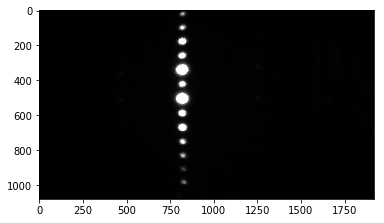

In [4]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()
#new_width = camera.Width.GetValue() - camera.Width.GetInc()
#if new_width >= camera.Width.GetMin():
#    camera.Width.SetValue(new_width)

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)

# Calculate e.g. a vertical blazed grating:
#blazePeriod = 77

# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
print(data)
error = slm.showPhasevalues(data)

#Change Threshold
COST = 999999999999999999
Threshold = 0.1
a = 0.5
def cost(I_target, I_camera):
    return np.sum((abs(I_target-I_camera))**2)/np.size(I_target)

# Set this appropriately, can load the .npy file into this, and resize probably
TargetIntensity = np.load('target_intensity_06_10.npy')

print(TargetIntensity.shape)
plt.imshow(TargetIntensity, cmap='gray', vmin=0, vmax=255)
plt.show()

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [128. 128. 128. ... 128. 128. 128.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]]
(1080, 1920)


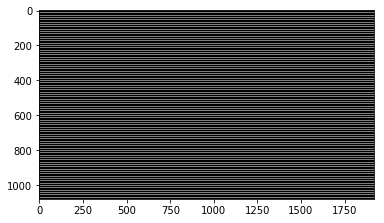

In [5]:
target_phase = np.loadtxt('target_phase_mask.dat.dat')
print(target_phase)
print(target_phase.shape)
plt.imshow(target_phase, cmap='gray', vmin=0, vmax=255)
plt.show()
target_phase = 2*np.pi*target_phase/255

In [6]:
numberOfImagesToGrab = 100

data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
data_init = data
data_error = []
data_error.append(cost(data_init, target_phase))
intensity_error = []
iter = 0
a = 0.5


time_start = time.time()
Threshold = 1
while iter in range(numberOfImagesToGrab) and (COST>Threshold):
    
    error = slm.showPhasevalues(data)
    #time.sleep(5)
    #input("Press Enter to continue...")
    
    camera.StartGrabbingMax(1)
    while camera.IsGrabbing():
        grabResult = camera.RetrieveResult(20000, pylon.TimeoutHandling_ThrowException)
        if grabResult.GrabSucceeded():
            # Access the image data.
            img = (np.asarray(grabResult.Array))**0.5 #.reshape((grabResult.Height, grabResult.Width))
        else:
            print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
        grabResult.Release()
            
            
    img_sliced = img[4:1084, 64:1984]
    img_sliced[0:1080, 0:336]=0
    I = img_sliced**2
    cv2.imwrite('with_phase_06_10/with_phase'+ str(iter) + '.png', I)
    COST = cost(TargetIntensity, I)
    intensity_error.append(COST)
    
    img_fb = np.fft.fftshift(np.fft.ifft2(np.multiply(a*img_sliced+(1-a)*(TargetIntensity)**0.5, np.cos(data) + 1j*np.sin(data)))) # Multiplying phase mask to output electric field amplitude
    #img_fb = np.fft.fftshift(np.fft.ifft2(a*img_sliced+(1-a)*(TargetIntensity)**0.5))
    #img_fb_phase = np.angle(img_fb)
    data = np.angle(img_fb)%(2*np.pi)

    #data = img_fb_phase
    #data = data%(2*np.pi)
    
    data_error.append(cost(target_phase, data))
    iter = iter + 1 
    

time_end = time.time()
print(data.shape)
print("TIME: ", time_end-time_start)
print("Converged in ", iter , " iterations")

(1080, 1920)
TIME:  758.8239006996155
Converged in  100  iterations


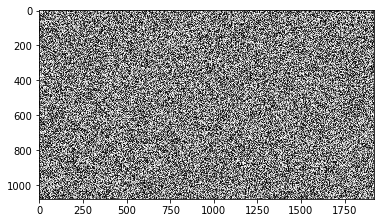

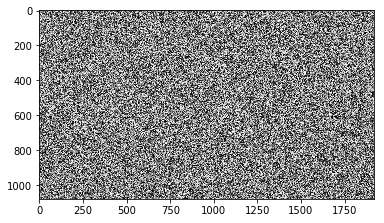

10847.607876694146
0.0
0.0
(1080, 1920)


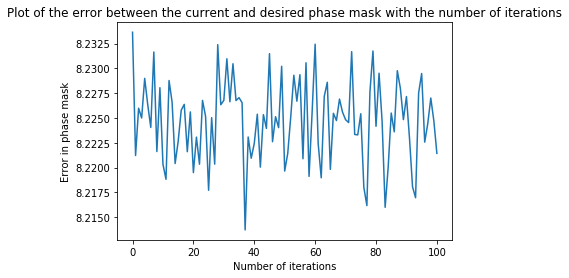

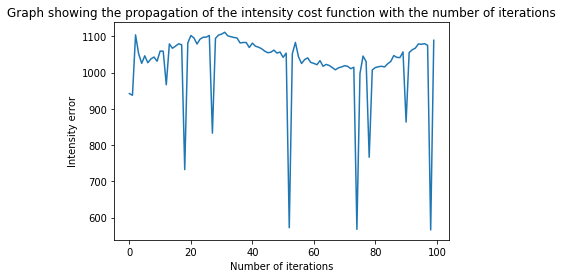

<Figure size 432x288 with 0 Axes>

In [7]:
data_final = data*255/(2*np.pi)
plt.imshow(data_final, cmap='gray', vmin=0, vmax=255)
plt.show()
np.save('final_mask_06_10_with_phase', data)

data_initial = data_init*255/(2*np.pi)
plt.imshow(data_initial, cmap='gray', vmin=0, vmax=255)
plt.show()
print(cost(data_final, data_initial))
print(cost(data, data))
print(cost(data_init, data_init))

print(data_init.shape)
n = np.arange(0, numberOfImagesToGrab + 1, 1)
plt.plot(n, data_error)
plt.xlabel('Number of iterations')
plt.ylabel('Error in phase mask')
plt.title('Plot of the error between the current and desired phase mask with the number of iterations')
plt.show()
plt.savefig('mask_error_06_10_with_phase.png')

m = np.arange(0, numberOfImagesToGrab, 1)
plt.plot(m, intensity_error)
plt.xlabel('Number of iterations')
plt.ylabel('Intensity error')
plt.title('Graph showing the propagation of the intensity cost function with the number of iterations')
plt.show()
plt.savefig('intensity_error_06_10_with_phase.png')

In [2]:
camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None


NameError: name 'camera' is not defined

In [ ]:
iter = 0
time_start = time.time()
while iter in range(100):
    
   
    camera.StartGrabbingMax(1)
    while camera.IsGrabbing():
        grabResult = camera.RetrieveResult(20000, pylon.TimeoutHandling_ThrowException)
        if grabResult.GrabSucceeded():
            # Access the image data.
            img = (np.asarray(grabResult.Array))**0.5 #.reshape((grabResult.Height, grabResult.Width))
        else:
            print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
        grabResult.Release()
            
            
    iter = iter + 1 
    

time_end = time.time()
print(data.shape)
print("TIME: ", time_end-time_start)

In [ ]:
time_start = time.time()
camera.StartGrabbingMax(100)
while camera.IsGrabbing():
    grabResult = camera.RetrieveResult(200000, pylon.TimeoutHandling_ThrowException)
    if grabResult.GrabSucceeded():
        # Access the image data.
        img = (np.asarray(grabResult.Array))**0.5 #.reshape((grabResult.Height, grabResult.Width))
    else:
        print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
    grabResult.Release()
        
time_end = time.time()
print(data.shape)
print("TIME: ", time_end-time_start)


In [ ]:
print(target_phase)

In [ ]:
print(data_final)

In [ ]:
a = np.random.uniform(0,1,(2000,2000)) + 1j*np.random.uniform(0,1,(2000,2000))
b = np.random.uniform(0,1,(2000,2000)) + 1j*np.random.uniform(0,1,(2000,2000))
time1 = time.time()
c = np.multiply(a,b)
time2 = time.time()
print(time2 - time1)